## Robustness of XAI explanations under natural noise conditions
>  *How much will attribution maps degrade?*

In [396]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import gc
import random

import shap
from captum.attr import Saliency, IntegratedGradients, GradientShap
from skimage.metrics import structural_similarity as ssim
from scipy.stats import spearmanr
from tqdm import tqdm

In [ ]:
# Reproducibility
torch.manual_seed(0);  np.random.seed(0);  random.seed(0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [397]:
plt.rcParams.update({'pdf.fonttype': 42, 'ps.fonttype': 42})

### Configuration

In [398]:
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_SAMPLES       = 30 #200                    # number of images to evaluate
NOISE_SIGMA     = np.linspace(0,1,21)        # std of Gaussian noise (0 ... 0.50)
METRIC          = "SSIM"                     # "SSIM" or "SPEARMAN"
SAVE_FIG        = "robustness_xai_mnist.pdf" # None → no save

### Data loading and preprocessing (`MNIST`)

In [400]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_ds = datasets.MNIST("./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True)

In [401]:
class CNN(nn.Module):
    def __init__(self, d1=0.25, d2=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3), nn.ReLU(),
            nn.Conv2d(32,64,3), nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Dropout2d(d1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*12*12,128), nn.ReLU(),
            nn.Dropout(d2), 
            nn.Linear(128,10)
        )
    def forward(self,x):
        x = self.features(x)
        return self.classifier(torch.flatten(x,1))

model = CNN().to(device)
# Reuse trained model
model.load_state_dict(torch.load("ex2_mnist_cnn.pth", map_location=device))
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Explainers
- Saliency (Vanilla Gradients)
- Integrated Gradients
- GradientSHAP
- DeepSHAP

In [402]:
# Explainer objects
saliency      = Saliency(model)
intgrad       = IntegratedGradients(model)
gshap         = GradientShap(model)

# DeepSHAP: sample 100 background images once
bg_imgs,_     = next(iter(DataLoader(test_ds, batch_size=100, shuffle=True)))
deep_shap_exp = shap.DeepExplainer(model, bg_imgs.to(DEVICE))

In [403]:
# def get_attr(name, method, inp, tgt):
#     if name == "IntegratedGradients":
#         return method.attribute(inp, target=tgt, n_steps=50)
#     if name == "GradientShap":
#         baselines = torch.randn_like(inp)*0.1
#         return method.attribute(inp, baselines=baselines, target=tgt, n_samples=50)
#     if name == "DeepShap":
#         sv = deep_explainer.shap_values(inp)   # this is a NumPy array of shape (B,1,28,28,10)
        
#         # NOTE: uncomment for visualization
#         # sv_reshaped = [np.transpose(sv[..., j], (0, 2, 3, 1)) for j in range(sv.shape[4])]
#         # ti_numpy = inp.cpu().numpy().transpose(0, 2, 3, 1)
#         # shap.image_plot(sv_reshaped, -ti_reshaped)
        
#         # move labels to CPU numpy
#         tgt_np = tgt.detach().cpu().numpy() if torch.is_tensor(tgt) else np.array(tgt)
#         # single‑sample case
#         if tgt_np.ndim == 0:
#             arr = sv[..., int(tgt_np)]          # shape (1,1,28,28)
#         else:
#             # batch case: pick for each i the sv[i,..., class_i]
#             arr = np.stack([sv[i,..., tgt_np[i]] for i in range(len(tgt_np))])  # (B,1,28,28)
#         return torch.from_numpy(arr).to(device)

#     return method.attribute(inp, abs=False, target=tgt)

In [404]:
def attribute(name, x, y):
    """Return attribution map  torch.Tensor shape=(1,1,28,28) in CHW,
    always on CPU numpy float32 in [-1,1]."""
    if name=="Gradient":
        attr = saliency.attribute(x, target=y, abs=False)
    elif name=="IntegratedGradients":
        attr = intgrad.attribute(x, target=y, n_steps=50)
    elif name=="GradientShap":
        baselines = torch.randn_like(x)*0.1                       # 𝐍(0,0.1)
        attr = gshap.attribute(x, target=y, baselines=baselines, n_samples=50)
    else:
        sv = deep_shap_exp.shap_values(x)   # this is a NumPy array of shape (B,1,28,28,10)
        
        # NOTE: uncomment for visualization
        # sv_reshaped = [np.transpose(sv[..., j], (0, 2, 3, 1)) for j in range(sv.shape[4])]
        # ti_numpy = inp.cpu().numpy().transpose(0, 2, 3, 1)
        # shap.image_plot(sv_reshaped, -ti_reshaped)
        
        # move labels to CPU numpy
        tgt_np = y.detach().cpu().numpy() if torch.is_tensor(y) else np.array(y)
        # single‑sample case
        if tgt_np.ndim == 0:
            arr = sv[..., int(tgt_np)]          # shape (1,1,28,28)
        else:
            # batch case: pick for each i the sv[i,..., class_i]
            arr = np.stack([sv[i,..., tgt_np[i]] for i in range(len(tgt_np))])  # (B,1,28,28)
        return torch.from_numpy(arr).to(device)
    # else:  # DeepSHAP
    #     sv = deep_shap_exp.shap_values(x)                         # list length =10
    #     attr = torch.from_numpy(sv[int(y.item())])                # SHAP for true class
    return attr.detach().cpu().float()

In [405]:
def similarity(a, b, metric="SSIM"):
    """Compute similarity between two attribution maps using SSIM or Spearman correlation."""
    if metric=="SSIM":
        # rescale each map into [0,1] – SSIM is intensity-scale sensitive
        a_ = (a-a.min())/(a.max()-a.min()+1e-6)
        b_ = (b-b.min())/(b.max()-b.min()+1e-6)
        return ssim(a_, b_, data_range=1.0)
    elif metric=="SPEARMAN":
        return spearmanr(a.flatten(), b.flatten()).correlation
    else:
        raise ValueError(metric)

### Main Loop

In [406]:
methods = ["Saliency","IntegratedGradients","GradientShap","DeepSHAP"]
results = {m:[] for m in methods}   # list of (mean, std) for each sigma

# Pre-collect a fixed image set that model classifies correctly
clean_imgs, clean_labels = [], []
for im,lbl in test_loader:
    im, lbl = im.to(DEVICE), lbl.to(DEVICE)
    if model(im).argmax(1).item()==lbl.item():
        clean_imgs.append(im.cpu());   clean_labels.append(lbl.cpu())
    if len(clean_imgs)==N_SAMPLES: break
clean_imgs  = torch.cat(clean_imgs)      # Nx1x28x28  on CPU
clean_lbls  = torch.cat(clean_labels)    # N

print(f"   using {N_SAMPLES} correctly-classified test images")

   using 30 correctly-classified test images


In [407]:
results = {m:[] for m in methods}   # list of (mean,std) for each sigma

# iterate noise levels
for sigma in tqdm(NOISE_SIGMA, desc="sigma", leave=False):
    # prepare noisy version once
    noise = torch.randn_like(clean_imgs)*sigma
    noisy_imgs = clean_imgs + noise
    noisy_imgs = torch.clamp(noisy_imgs, -1.0, 1.0)              # stay in normalized range

    # optionally drop samples whose prediction flipped after noise
    preds_noisy = model(noisy_imgs.to(DEVICE)).argmax(1).cpu()
    keep = preds_noisy==clean_lbls
    if keep.sum()==0:                                           # all flipped
        for m in methods: results[m].append((np.nan,np.nan));   continue
    imgs0, imgs1 = clean_imgs[keep], noisy_imgs[keep]
    lbls0        = clean_lbls[keep]

    for m in methods:
        sim_vals=[]
        for i in range(len(imgs0)):
            x0 = imgs0[i:i+1].to(DEVICE)
            x1 = imgs1[i:i+1].to(DEVICE)
            y  = lbls0[i:i+1].to(DEVICE)
            a0 = attribute(m,x0,y).cpu().squeeze().numpy()
            a1 = attribute(m,x1,y).cpu().squeeze().numpy()
            sim_vals.append(similarity(a0,a1, METRIC))
            # free GPU 
            del a0,a1,x0,x1,y;  torch.cuda.empty_cache()
        sim_vals = np.array(sim_vals)
        results[m] = results[m][:len(NOISE_SIGMA)]
        results[m].append((sim_vals.mean(), sim_vals.std(ddof=1)))
    gc.collect(); torch.cuda.empty_cache()

### Visualizations

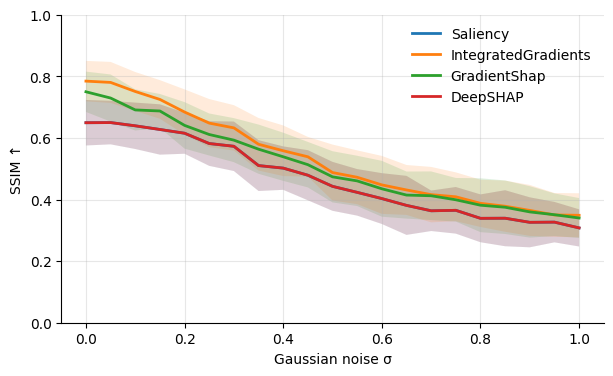

In [408]:
# 4) PLOT ──────────────────────────────────────────────────────
fig,ax = plt.subplots(figsize=(7,4))
for m,c in zip(methods,["tab:blue","tab:orange","tab:green","tab:red"]):
    means = [mu for mu, _ in results[m]]
    stds  = [sigma for _, sigma in results[m]]
    ax.plot(NOISE_SIGMA,means,label=m,lw=2)
    ax.fill_between(NOISE_SIGMA, np.array(means)-stds, np.array(means)+stds,
                    alpha=.15)
ax.set_xlabel("Gaussian noise sigma")
ax.set_ylabel(f"{METRIC} ↑")
#ax.set_title("Explanation robustness vs. input noise (MNIST)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
ax.set_ylim(0,1)
if SAVE_FIG: plt.savefig(SAVE_FIG,bbox_inches="tight")
plt.show()

### Summary
- Area Under Stability Curve (under similarity cirve) to rank methods

In [409]:
# 5) INTEGRATED SUMMARY ───────────────────────────────────────
#   AU-Stability-Curve (area under similarity curve) to rank methods
auc = {m: np.trapz([mu for mu,_ in results[m]], NOISE_SIGMA)/NOISE_SIGMA[-1]
       for m in methods}   # normalised to [0,1]

print("AUC-robustness score (1 = perfectly stable, 0 = random):")
for m,s in sorted(auc.items(), key=lambda kv: kv[1], reverse=True):
    print(f"{m:<18s}{s:7.3f}")


AUC-robustness score (1 = perfectly stable, 0 = random):
IntegratedGradients  0.530
GradientShap        0.509
DeepSHAP            0.468
Saliency            0.468


### Signla-sample explanation grid across noise levels

In [411]:
#noise_levels = NOISE_SIGMA
noise_levels = np.arange(0.0, 1.1, 0.25)

x_clean      = clean_imgs[sample_idx:sample_idx+1] # 1x1x28x28
y_true       = clean_lbls[sample_idx].item()

# generate noisy versions and predictions
noisy_samples, preds = [], []
for sigma in noise_levels:
    noise   = torch.randn_like(x_clean) * sigma
    x_noisy = torch.clamp(x_clean + noise, -1.0, 1.0)
    noisy_samples.append(x_noisy)
    preds.append(int(model(x_noisy.to(DEVICE)).argmax(1).item()))

# Check for incorrect predictions
incorrect_indices = []
for i, (pred, sigma) in enumerate(zip(preds, noise_levels)):
    if pred != y_true:
        incorrect_indices.append(i)
        print(f"Incorrect prediction at noise level sigma={sigma:.2f} (index {i}): predicted {pred}, true {y_true}")

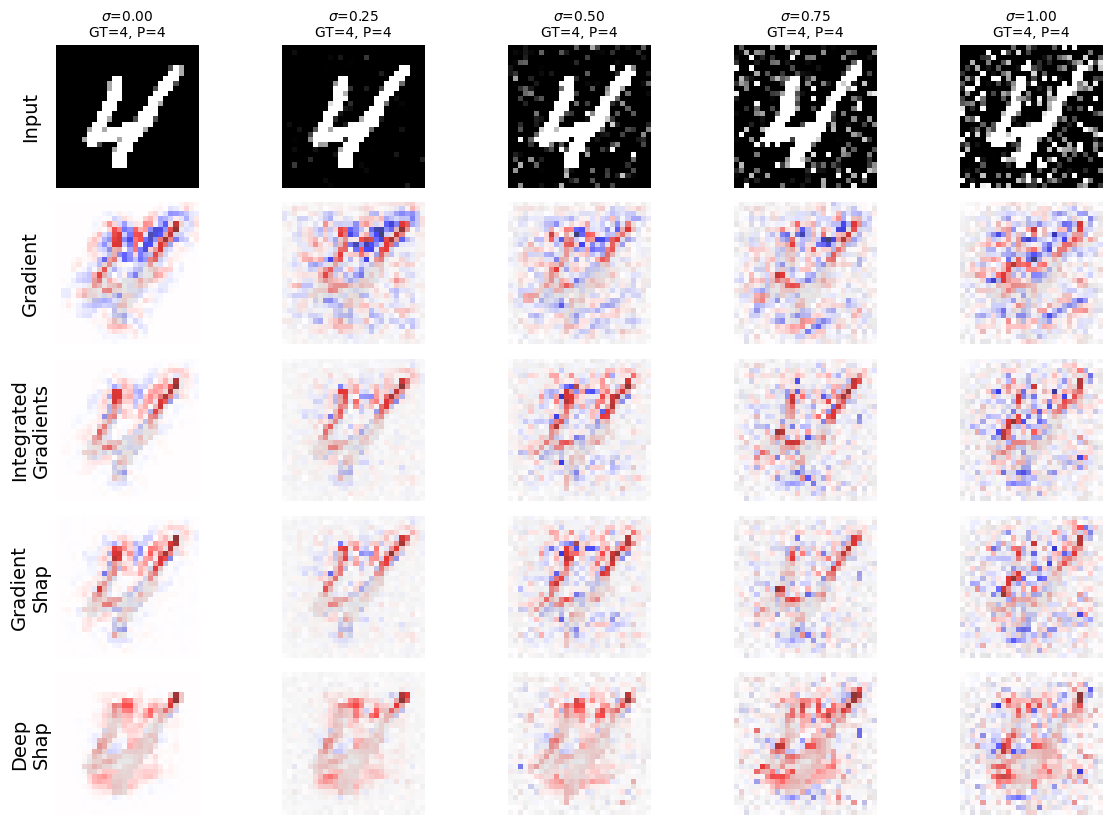

In [413]:
sample_idx   = 4

# row labels & plot grid
row_labels = ["Input",
              "Gradient",
              "Integrated\nGradients",
              "Gradient\nShap",
              "Deep\nShap"]

n_rows = len(row_labels)
n_cols = len(noise_levels)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(3*n_cols, 2*n_rows))
                         #squeeze=False)
vmin, vmax = -1, 1

for r in range(n_rows):
    for c, sigma in enumerate(noise_levels):
        ax = axes[r, c]
        ax.axis('off')

        x_noisy = noisy_samples[c]
        im_np    = x_noisy.cpu().squeeze().numpy()

        if r == 0:
            # show noisy input, plus GT & pred
            ax.imshow(im_np, cmap='gray', vmin=0, vmax=1)
            ax.set_title(r"$\sigma$"+f"={sigma:.2f}\nGT={y_true}, P={preds[c]}",fontsize=10)
        else:
            method_name = row_labels[r].replace("\n", "")
            # compute attribution
            attr = attribute(method_name,
                             x_noisy.to(DEVICE),
                             torch.tensor([y_true], device=DEVICE))
            a_np = attr.cpu().squeeze().numpy()
            norm = a_np / (np.abs(a_np).max() + 1e-8)
            # overlay on noisy input
            ax.imshow(im_np, cmap='gray_r', alpha=0.3)
            ax.imshow(norm, cmap='seismic', vmin=vmin, vmax=vmax, alpha=0.7)

        if c == 0: # row label on first column
            axes[r, 0].text(-0.18, 0.5, row_labels[r],
                            transform=ax.transAxes,
                            rotation=90,
                            va='center',
                            ha='center',
                            fontsize=14)

plt.subplots_adjust(left=0.15, wspace=0.02, hspace=0.1)
#plt.savefig("figures/ex3a_robustness_xai_mnist_single.pdf", bbox_inches="tight")
plt.show()